### Optional - Redo with few selected features, and std() for variance measure.

Using **`.corr()`** and **`.heatmap()`** are helpful in selecting features that meet the assumptions behind linear regression. One of the key assumptions is that variables are independent of each other. So the features you select should not have really high positive or negative correlation.


brendanbailey [Sep 24th at 3:16 PM] Sun Sep 24, 2017

Great job! A couple of things:
* For the linear regression you used all variables. Unfortunately, the variables are not independent of each other which can result in issues with multicollinearity. You should pick a subset of variables that are not correlated with each other but you suspect will be a good predictor of the target variable
* For the k folds, if you want to get a measure of variance then you could use `np.std()` on each of the lists of scores


for folds in range(5, 11):

    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv=folds)
    print str(folds), ‘Cross-Validated Scores:‘, scores
    predictions = cross_val_predict(model, X, y, cv=folds)
    accuracy = metrics.r2_score(y, predictions)
    print str(folds), ‘Cross-Predicted Accuracy:‘, accuracy
    print
    
Use: print "standard deviation:", np.std(scores)



<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

_Authors: _

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [195]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston

In [197]:
boston = load_boston()

In [198]:
X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [199]:
# MEDV = median value
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])
y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [6]:
print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [7]:
# Exploratory data analysis.

# Include: 
# 1 - total nulls, 
# 2 - index, 
# 3 - data types, 
# 4 - shape, 
# 5 - summary statistics, and 
# 6 - the number of unique values for each column


In [8]:
X.columns

Index([u'CRIM', u'ZN', u'INDUS', u'CHAS', u'NOX', u'RM', u'AGE', u'DIS',
       u'RAD', u'TAX', u'PTRATIO', u'B', u'LSTAT'],
      dtype='object')

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [10]:
# 1 - total nulls
X.isnull().sum()   # no null values

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [11]:
# 2 - index
X.index

RangeIndex(start=0, stop=506, step=1)

In [12]:
# 3 - data types
X.dtypes   # all type float objects

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [13]:
# 4 - shape
X.shape      # (rows, cols)

(506, 13)

In [14]:
# 5 - summary statistics
X.describe().T              # describe requires (); transpose to see all columns

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.593761,8.596783,0.00632,0.082045,0.25651,3.647423,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [15]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [16]:
# 6 - number of unique values for each column

# print 'CRIM', X.CRIM.nunique()
# print 'ZN', X.ZN.nunique()
# print 'INDUS', X.INDUS.nunique()
# print 'CHAS', X.CHAS.nunique()
# print 'NOX', X.NOX.nunique()
# print 'RM', X.RM.nunique()
# print 'AGE', X.AGE.nunique()
# print 'DIS', X.DIS.nunique()
# print 'RAD', X.RAD.nunique()
# print 'TAX', X.TAX.nunique()
# print 'PTRATIO', X.PTRATIO.nunique()
# print 'B', X.B.nunique()
# print 'LSTAT', X.LSTAT.nunique()

for column in X.columns:
    print column, X[column].nunique()

CRIM 504
ZN 26
INDUS 76
CHAS 2
NOX 81
RM 446
AGE 356
DIS 412
RAD 9
TAX 66
PTRATIO 46
B 357
LSTAT 455


In [17]:
# Stefan: another way using a series method
# X.apply(pd.Series.nunique).sort_values()

# Stefan: see which are categorical vs. continuous in nature
X.apply(lambda x: x.nunique()).sort_values()

CHAS         2
RAD          9
ZN          26
PTRATIO     46
TAX         66
INDUS       76
NOX         81
AGE        356
B          357
DIS        412
RM         446
LSTAT      455
CRIM       504
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions.

#### Comment: I don't really know the best way to figure this part out.

In [200]:
X.corr() # max correlations: 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


In [19]:
# sns.pairplot(X)

In [20]:
# features = ['CRIM', 'TAX']
# X[features].corr()

In [69]:
# NOX=nitric oxide, DIS=distance employment center, AGE=owner occupied built prior to 1940?
# sns.pairplot(X[features])

** Comment: ** I'm not sure how to determine the best features, so all features will be used in the train-test-split scenarios, below.

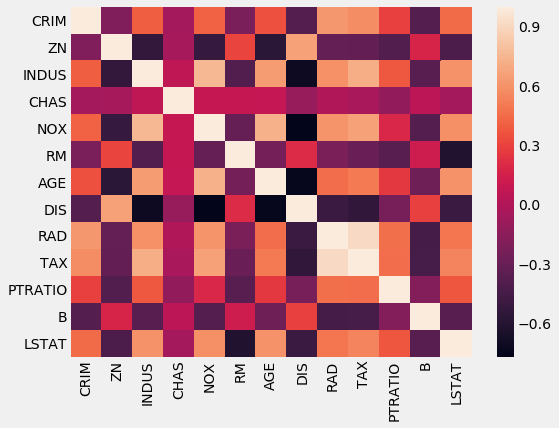

In [201]:
sns.heatmap(X.corr());

### 2a. Perform 50/50 test-train split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=8) # with random sampling

In [24]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [25]:
model = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test)          # default coefficient of determination for prediction is R^2

0.71068895272802557

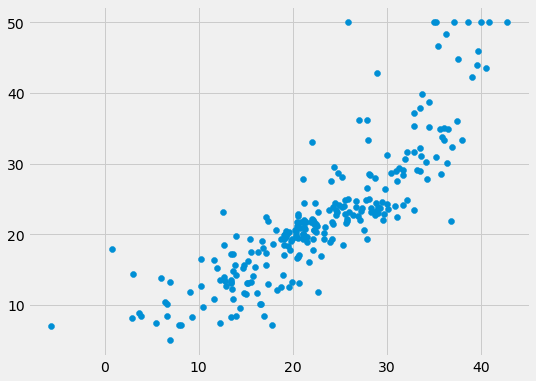

In [26]:
plt.scatter(predictions, y_test)

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change?

### 3a. 70/30 train-test split

In [ ]:
# from sklearn.model_selection import train_test
# from sklearn.linear_model import LinearRegression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=8) # with random sampling

In [28]:
model = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test) # default coefficient of determination for prediction is R^2

0.70799341124726012

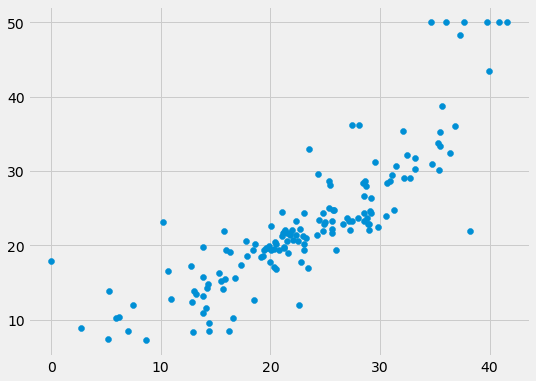

In [29]:
plt.scatter(predictions, y_test)

### 3b. 90/10 train-test split

In [ ]:
# from sklearn.model_selection import train_test
# from sklearn.linear_model import LinearRegression

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=8) # with random sampling

In [31]:
model = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test) # default coefficient of determination for prediction is R^2

0.68079787628483035

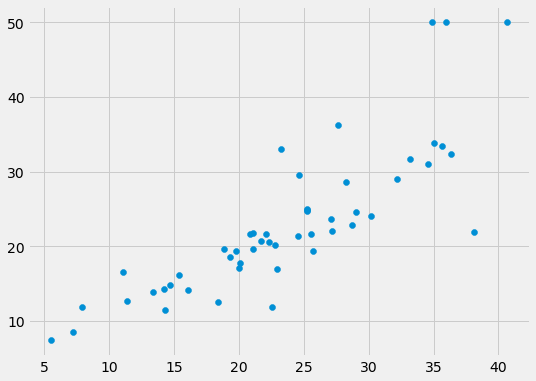

In [32]:
plt.scatter(predictions, y_test)

#### Q: How do your metrics change?

Decreasing amount of data amounts to fewer predictions, results in a reduction of R^2.  Note: Test set goes from 50% to 30% to 10%.

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score.

In [33]:
# from sklearn.model_selection import train_test
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [34]:
for folds in range(5, 11):
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv=folds)
    print str(folds), 'Cross-Validated Scores:', scores
    predictions = cross_val_predict(model, X, y, cv=folds)
    accuracy = metrics.r2_score(y, predictions)
    print str(folds), 'Cross-Predicted Accuracy:', accuracy
    print

5 Cross-Validated Scores: [ 0.63861069  0.71334432  0.58645134  0.07842495 -0.26312455]
5 Cross-Predicted Accuracy: 0.559652434646

6 Cross-Validated Scores: [ 0.64224005  0.61152091  0.51447066  0.78503274 -0.14367345 -0.01539034]
6 Cross-Predicted Accuracy: 0.537671767736

7 Cross-Validated Scores: [ 0.65289125  0.59571869  0.67862548  0.61141877  0.51888956 -0.27835015
  0.39774739]
7 Cross-Predicted Accuracy: 0.564584520386

8 Cross-Validated Scores: [ 0.75014285  0.42039086  0.71854702  0.57190316  0.75650376 -0.37306354
 -0.35181135  0.33556184]
8 Cross-Predicted Accuracy: 0.620582930393

9 Cross-Validated Scores: [ 0.7414133   0.4777157   0.5777252   0.58038448  0.64917642  0.70816441
 -0.14095944 -0.5491727   0.37669769]
9 Cross-Predicted Accuracy: 0.593840427406

10 Cross-Validated Scores: [ 0.73334917  0.47229799 -1.01097697  0.64126348  0.54709821  0.73610181
  0.37761817 -0.13026905 -0.78372253  0.41861839]
10 Cross-Predicted Accuracy: 0.590177393332



In [35]:
for folds in range(5, 11):
    lr = LinearRegression()
    scores = cross_val_score(lr, X_train, y_train, cv=folds)
    print str(folds), 'Cross-Validated Scores:', scores
    predictions = cross_val_predict(model, X_test, y_test, cv=folds)
    accuracy = metrics.r2_score(y_test, predictions)
    print str(folds), 'Cross-Predicted Accuracy:', accuracy
    print

5 Cross-Validated Scores: [ 0.7310341   0.71116734  0.79748423  0.65151326  0.59540812]
5 Cross-Predicted Accuracy: 0.406642297378

6 Cross-Validated Scores: [ 0.75695637  0.7336252   0.72949534  0.71607209  0.68669686  0.61731407]
6 Cross-Predicted Accuracy: 0.42247751742

7 Cross-Validated Scores: [ 0.73649078  0.70546698  0.75888779  0.76175865  0.72145572  0.66341562
  0.55010929]
7 Cross-Predicted Accuracy: 0.441734839927

8 Cross-Validated Scores: [ 0.69384559  0.72240216  0.82415326  0.6791991   0.78425579  0.58855513
  0.81466226  0.37976952]
8 Cross-Predicted Accuracy: 0.44279141739

9 Cross-Validated Scores: [ 0.75207266  0.69742075  0.7623421   0.7072293   0.78026808  0.66992467
  0.65066413  0.79927666  0.36591094]
9 Cross-Predicted Accuracy: 0.465948636484

10 Cross-Validated Scores: [ 0.75790965  0.69501916  0.70239548  0.73203965  0.76150378  0.83577713
  0.6444816   0.65302231  0.72555546  0.38274054]
10 Cross-Predicted Accuracy: 0.480357662838



#### Q: What seems optimal?

8 folds with a Cross-Predicted Accuracy = 0.620582930393 when applying the technique to the entire dataset.

#### Q: How do your scores change?

Appears to result in less accuracy for train-test split application.

#### Q: What is the variance like?

Not seeing a significant pattern.  Use np.std() on each of the lists of scores...

### 4a.  Try different folds to get a sense of how this impacts your score.

In [44]:
for folds in range(3, 35):
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv=folds)
#     print str(folds), 'Cross-Validated Scores:', scores
#     print "standard deviation:", np.std(scores)   # try this for variance measure
    predictions = cross_val_predict(model, X, y, cv=folds)
    accuracy = metrics.r2_score(y, predictions)
    print str(folds), 'Cross-Predicted Accuracy:', accuracy
    print

3 Cross-Predicted Accuracy: -0.991116576007

4 Cross-Predicted Accuracy: 0.497487686498

5 Cross-Predicted Accuracy: 0.559652434646

6 Cross-Predicted Accuracy: 0.537671767736

7 Cross-Predicted Accuracy: 0.564584520386

8 Cross-Predicted Accuracy: 0.620582930393

9 Cross-Predicted Accuracy: 0.593840427406

10 Cross-Predicted Accuracy: 0.590177393332

11 Cross-Predicted Accuracy: 0.623015241953

12 Cross-Predicted Accuracy: 0.603842032442

13 Cross-Predicted Accuracy: 0.613456454915

14 Cross-Predicted Accuracy: 0.636119234008

15 Cross-Predicted Accuracy: 0.615214016736

16 Cross-Predicted Accuracy: 0.618473869509

17 Cross-Predicted Accuracy: 0.616097522545

18 Cross-Predicted Accuracy: 0.65419933487

19 Cross-Predicted Accuracy: 0.625106244785

20 Cross-Predicted Accuracy: 0.624768555501

21 Cross-Predicted Accuracy: 0.635487615053

22 Cross-Predicted Accuracy: 0.666900735949

23 Cross-Predicted Accuracy: 0.629732938236

24 Cross-Predicted Accuracy: 0.631939573943

25 Cross-Predicte

#### Q: How does this impact your score?

Accuracy appears to improve more consistently with greater than 10 folds.

# KNN Practice

In [50]:
# Read the iris data into a DataFrame
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# iris = pd.read_csv(url)
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [49]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [51]:
# Allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [52]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [53]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = [0 if x == 'Iris-setosa' else 1 if x == 'Iris-versicolor' else 2 for x in iris.species]

In [59]:
# see new column with assigned species_num
print iris['species_num'].head()
print iris['species_num'].tail()

0    0
1    0
2    0
3    0
4    0
Name: species_num, dtype: int64
145    2
146    2
147    2
148    2
149    2
Name: species_num, dtype: int64


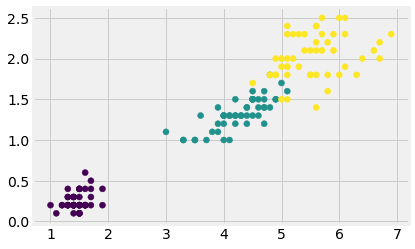

In [66]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
# plt.scatter(x=iris['petal_length'], y=iris['petal_width'], c=iris['species_num'])
plt.scatter(x=iris.petal_length, y=iris.petal_width, c=iris.species_num)
plt.show()

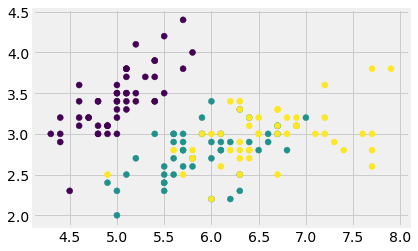

In [63]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
plt.scatter(x=iris['sepal_length'], y=iris['sepal_width'], c=iris['species_num'])
plt.show()

**Conclusion:** petal_length vs. petal_width appears to offer clearer classification boudaries, than sepa_length vs. sepal_width.

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [78]:
# features set
X = iris.drop(['species_num', 'species'], axis=1)
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [146]:
# response vector
y = iris['species_num']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: species_num, dtype: int64

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) # 70/30 train-test split

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [149]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [150]:
knn.score(X_test, y_test)

0.9555555555555556

** Comment: ** Easy test set to classify.

### Create a Model With Five Neighbors. Did it Improve?

In [151]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)
knn_5.score(X_test, y_test)

0.97777777777777775

** Comment: ** Increase in number of neighbors clarifies edge cases to improve accuracy for this 70/30 train-split dataset.

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

3 0.977777777778


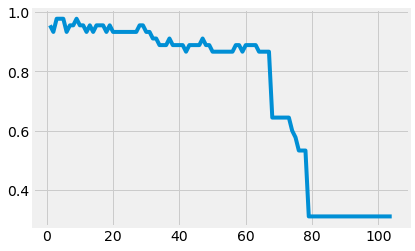

In [152]:
knn_scores = {}                                              # dictionary {k: score, ...}, where k is the number of neighbors
max_score = 0
max_k = 0

for num_neighbors in range(1,len(X_train)):                  # iterate over every observation in the training set
    knn = KNeighborsClassifier(n_neighbors = num_neighbors)  # sets number of neighbors for current iteration in KNN model
    knn.fit(X_train, y_train)                                # fits observations to training data
    score = knn.score(X_test, y_test)                        # applies model to test data and determines accuracy
    knn_scores[num_neighbors] = score                        # adds accuracy score to dictionary per k (number of neighbors)
    if score > max_score:                                    # determine the k (number of neighbors) with the highest accuracry score
        max_score = score
        max_k = num_neighbors
print max_k, max_score                                       # show the results

# plt.plot(knn_scores.keys(), knn_scores.values())           # plot the results with the object identifier - no ";"
plt.plot(knn_scores.keys(), knn_scores.values());            # plot the results without object identifier ";"

** Conclusion: ** Maximum accuracy with 3 neighbors.  Beyond about 67 neighbors, the accuracy declines rapidly and provides diminishing benefit for classifying species for the 70/30 train-test split for this dataset.

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

** A: ** knn.predict_proba(X) provides a measure of confidence that the classification for a given set of observations actually belongs to the predicted category or class, as a probablity value between 0 and 1 (for each observation in X).  For example, an edge case observation that is equidistant from the adjacent 2 classes would have a 0.5 (50%) probablity of being correctly classified.  An observation that has a probability closer to 0 would be a low confidence  classification, and a probability closer 1 would indicate high certainty that the prediction was correctly classified.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [186]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [182]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf


# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

# Ordinary Least Squares (OLS)
model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

print result.summary()

# Note: Model estimation - simple linear regression in second section, with intercept removed.

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     78.39
Date:                Sat, 23 Sep 2017   Prob (F-statistic):           2.86e-48
Time:                        20:15:34   Log-Likelihood:                -124.45
No. Observations:                 150   AIC:                             264.9
Df Residuals:                     142   BIC:                             289.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM            -0.2224      0.065     -3.416      0.0

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [189]:
# Check out variable relations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.pairplot()

In [ ]:
# Check out Pearson scores


## Demo: Patsy - A formula language (from R)
Allows expressions of variables and transformations of these variables (as opposed to matrices), in an equation format.  Uses "~" tilde for equal symbol.

In [174]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [175]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [176]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print "R^2 Score: ", metrics.r2_score(y_test, predictions)

R^2 Score:  0.0147462562056
